# No priority

Average waiting time is:  43.67750192461299
With the Confidence Interval:  39.669922577423115 47.685081271802865
Confidence Interval Size:  8.01515869437975


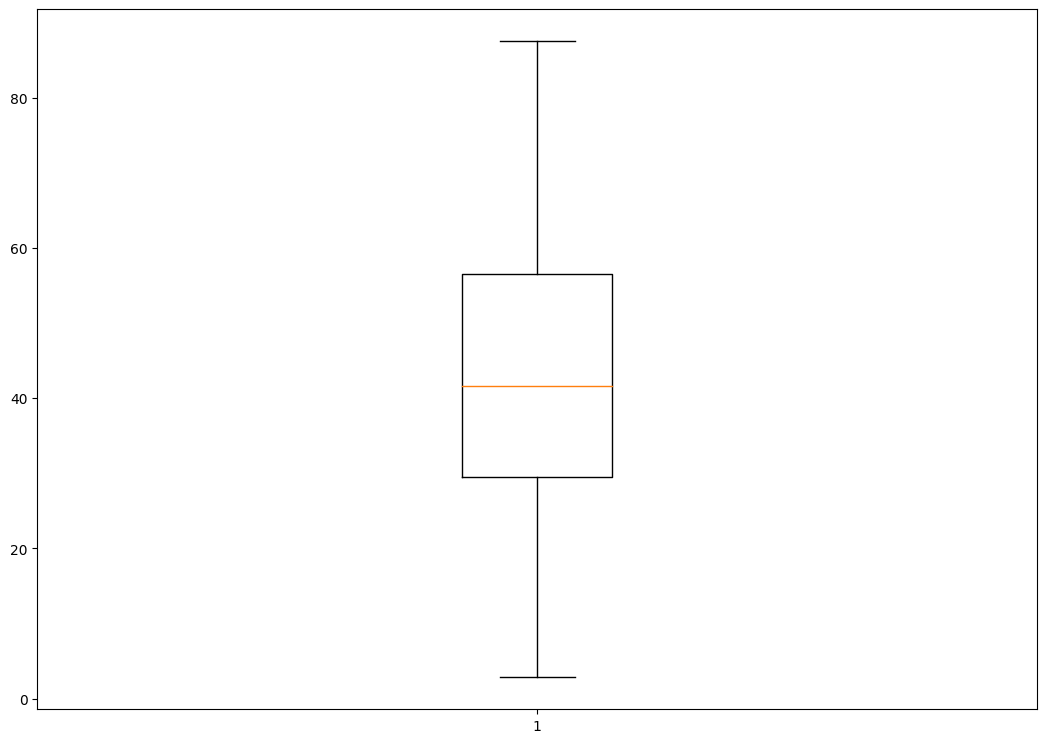

In [54]:
import simpy
import numpy as np

# Confidence Interval calculation
from scipy.stats import t
def confidence_interval(simulation_results, confidence=0.95, output_results=True):
    mean = np.mean(simulation_results)
    std = np.std(simulation_results)
    degree = len(simulation_results) - 1 
    t_crit = np.abs(t.ppf((1-confidence)/2, degree))    # Find the inverse cumulative distribution.
    ci = std*t_crit/np.sqrt(len(simulation_results))
    if output_results:
        print("Average waiting time is: ", mean)
        conf_int_low = mean-ci
        conf_int_high = mean+ci
        print("With the Confidence Interval: ", conf_int_low, conf_int_high)
        print("Confidence Interval Size: ", conf_int_high-conf_int_low)
        return
    else: return mean, ci

jobs_to_process = 300   # Max number of customers
runtime_limit = 400.0   # Runtime limit
seed = 42               # Seed for simulation

# miu
job_rate = 25.0   # Mean time in bank
# lambda
arrival_rate = 5.0  # Mean of arrival process
# n
servers_amount = 4



def Customer(env, name, resources):
    arrive = env.now

    # Getting Status of Queues
    queue_size = []
    for queue in resources:
        queue_size.append(len(queue.put_queue) + len(queue.users))

    # Choosing a Queue for an arrived Client
    choice = np.argmin(queue_size)
    
    with resources[choice].request() as req:
        # Wait for the Server
        yield req
        waiting_times.append(env.now - arrive)
        # Starting the Job
        job_duration = np.random.exponential(job_rate)
        yield env.timeout(job_duration)

def Source(env, jobs_to_process, arrival_rate, resources):
    for i in range(jobs_to_process):
        c = Customer(env, 'Process ' + str(i), resources)
        env.process(c)
        t = np.random.exponential(arrival_rate)
        yield env.timeout(t)


# Starting Simulation
trials = 100
np.random.seed(seed)
waiting_times_trials = []
for i in range(trials):
    waiting_times = []      # Waiting times of performed jobs
    # Setup trial
    env = simpy.Environment()
    # Creating Queues
    #res=PriorityResource(env, capacity=1)
    resources = []
    for n in range (servers_amount):
        resources.append(simpy.Resource(env))
    env.process(Source(env, jobs_to_process, arrival_rate, resources))
    #env.process(Source(env, jobs_to_process, arrival_rate, res))
    env.run(until=runtime_limit)

    waiting_times_trials.append(np.mean(waiting_times))     # Saving Results

confidence_interval(waiting_times_trials)



# Visualization
import matplotlib.pyplot as plt

data = [waiting_times_trials]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

plt.show()

# With Priority

Average waiting time is:  23.009385079911553
With the Confidence Interval:  21.371224283076167 24.64754587674694
Confidence Interval Size:  3.2763215936707724


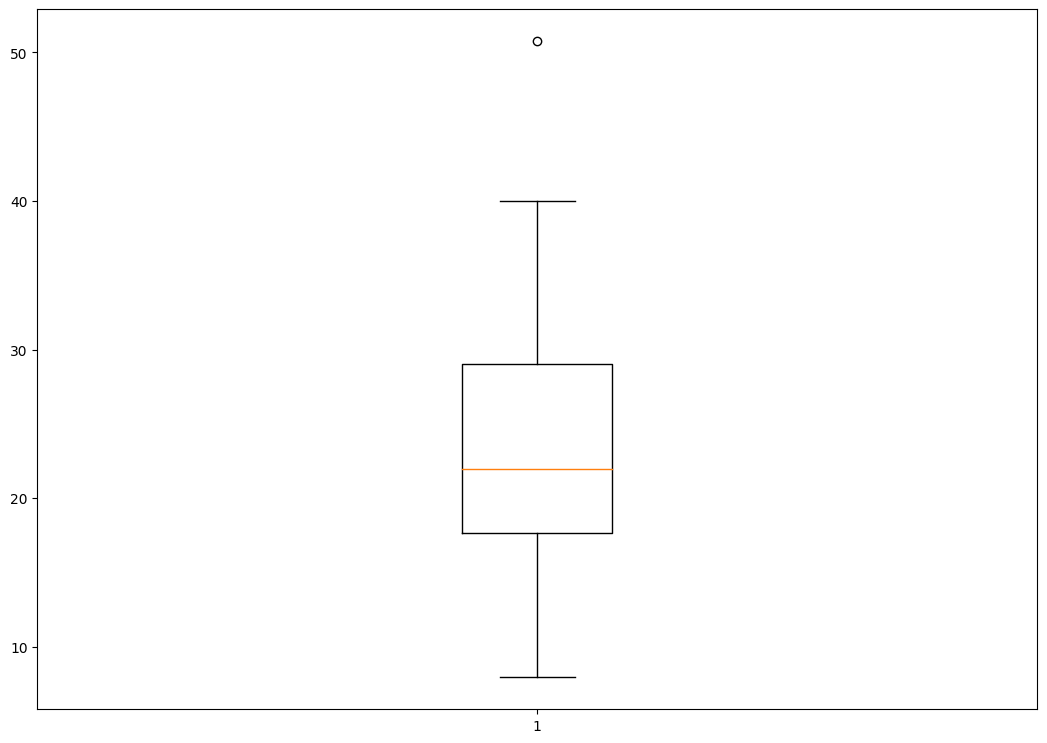

In [53]:
import simpy
import numpy as np

# Confidence Interval calculation
from scipy.stats import t
def confidence_interval(simulation_results, confidence=0.95, output_results=True):
    mean = np.mean(simulation_results)
    std = np.std(simulation_results)
    degree = len(simulation_results) - 1 
    t_crit = np.abs(t.ppf((1-confidence)/2, degree))    # Find the inverse cumulative distribution.
    ci = std*t_crit/np.sqrt(len(simulation_results))
    if output_results:
        print("Average waiting time is: ", mean)
        conf_int_low = mean-ci
        conf_int_high = mean+ci
        print("With the Confidence Interval: ", conf_int_low, conf_int_high)
        print("Confidence Interval Size: ", conf_int_high-conf_int_low)
        return
    else: return mean, ci

jobs_to_process = 300   # Max number of customers
runtime_limit = 400.0   # Runtime limit
seed = 42               # Seed for simulation

# miu
job_rate = 25.0   # Mean time in bank
# lambda
arrival_rate = 5.0  # Mean of arrival process
# n
servers_amount = 4



def Customer(env, name, resources):
    arrive = env.now

    # Creating job duration and assigning priority based on it
    job_duration = np.random.exponential(job_rate)

    # Getting Status of Queues
    queue_size = []
    for queue in resources:
        queue_size.append(len(queue.put_queue) + len(queue.users))

    # Choosing a Queue for an arrived Client
    choice = np.argmin(queue_size)
    
    with resources[choice].request(priority=job_duration) as req:
        # Wait for the Server
        yield req
        waiting_times.append(env.now - arrive)
        # Starting the Job
        yield env.timeout(job_duration)

def Source(env, jobs_to_process, arrival_rate, resources):
    for i in range(jobs_to_process):
        c = Customer(env, 'Process ' + str(i), resources)
        env.process(c)
        t = np.random.exponential(arrival_rate)
        yield env.timeout(t)


# Starting Simulation
trials = 100
np.random.seed(seed)
waiting_times_trials = []
for i in range(trials):
    waiting_times = []      # Waiting times of performed jobs
    # Setup trial
    env = simpy.Environment()
    # Creating Queues
    #res=PriorityResource(env, capacity=1)
    resources = []
    for n in range (servers_amount):
        resources.append(simpy.PriorityResource(env))
    env.process(Source(env, jobs_to_process, arrival_rate, resources))
    #env.process(Source(env, jobs_to_process, arrival_rate, res))
    env.run(until=runtime_limit)

    waiting_times_trials.append(np.mean(waiting_times))     # Saving Results

confidence_interval(waiting_times_trials)



# Visualization
import matplotlib.pyplot as plt

data = [waiting_times_trials]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

plt.show()